<a href="https://colab.research.google.com/github/D-Mayerfeld/intro-numerical-methods/blob/master/09a_ODE_BVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table>
 <tr align=left><td><img align=left src="https://github.com/D-Mayerfeld/intro-numerical-methods/blob/master/images/CC-BY.png?raw=1">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  The presentation below largely follows part I in "Finite Difference Methods for Ordinary and Partial Differential Equations" by LeVeque (SIAM, 2007).

In [ ]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Solving Boundary Value Problems

## The Problem

We want to solve an ODE (PDE) that instead of having initial conditions is contained to an interval and has values at the edges of the interval.  This naturally comes about when we consider spatial problems.  One of the simplest cases for this is the Poisson problem in one-dimension

$$
    u_{xx} = f(x)
$$

where we will use the short-hand

$$
    u_{xx} = \frac{\text{d}^2 u}{\text{d} x^2} \quad \text{or} \quad \frac{\partial^2 u}{\partial x^2}.
$$

Note that due to the order of the derivative we require two conditions to solve this.  The simplest case where we are on the domain $x \in [a,b]$ is to have conditions such that we require $u(a) = u_a$ and $u(b) = u_b$ and are commonly termed boundary value problems (BVP).  If these conditions are both at one end of the domain then we can actually phrase the ODE (PDE) again as an initial value problem (IVP).  So what do we need to do to solve these types of problems?  We will consider several approaches to this problem:

1. Recast our BVP to an IVP and use our standard methods for ODEs in a *shooting method*
1. Use finite differences to represent the unknowns as a linear system and solve the resulting system.
1. Use finite differences and Newton's method to solve non-linear BVP's
1. Use Galerkin finite elements to find the best-fit piecewise linear function that satisfies the ODE

## The Shooting Method

The shooting method takes the approach that we want to use our ability to solve IVP problems and so tries to rewrite the problem as a root finding problem for the higher order initial condition that we are not given.  This is best illustrated by an example.

Consider the problem
$$
    u_{xx} + \sin u = 0
$$

with
$$
    x \in [0, 2] \quad \text{and} \quad u(0) = 0.0, \quad u(2.0) = \frac{\pi}{2}.
$$

Reminder: we don't solve second order equations, we solve systems of first order equations.

We can rewrite this problem as a system of two first order ODEs by defining

$$
    \mathbf{v} = \begin{bmatrix} u \\ u_x \end{bmatrix} = \begin{bmatrix} v_1 \\ v_2 \end{bmatrix}
$$

then setting

$$
    \frac{d}{dx}\mathbf{v} = \mathbf{f}(\mathbf{v}) =  \begin{bmatrix} v_2 \\ -\sin v_1 \end{bmatrix}
$$

We know that we want $v_1(0) = 0$ but what do we use for $v_2(0)$?  Making an initial guess at $v_2(0)$ and solving the associated ODE IVP, we can then find out what these initial conditions produce on the right boundary of the problem.  Using a root-finding approach (or minimization routine) we can write this procedure as
$$
    \min_{v_2(0)} \left | \pi / 2 - v_1(2) \right |
$$
where the parameter we vary is $v_2(0)$.

This makes it a shooting method since you are "guessing" and minimizing the error for the second initial value.
- This then turns in to a root finder of the error function in which you input the ODE...

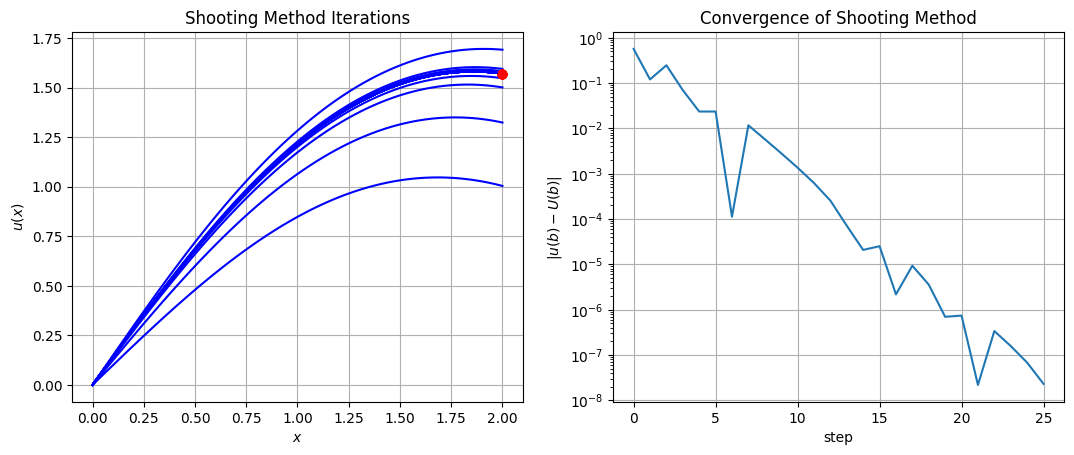

In [ ]:
# Basic Shooting Method solving u_xx -sin(u) = 0
from scipy.integrate import solve_ivp

# Algorithm parameters
TOLERANCE = 1e-8
MAX_ITERATIONS = 100

# Problem Statement
a = 0.0
b = 2.0
N = 100
x = numpy.linspace(a, b, N)
u_a = 0.0
u_b = numpy.pi / 2.0

# RHS function
def f(x, u):
    return numpy.array([u[1], -numpy.sin(u[0])])

# Initial guess
# Slope at RHS
u_prime_rhs = 1.0
# Initial step size
du_prime = 0.5

# Plotting
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)

# Main loop
success = False
u = numpy.empty((2, N))
u0 = numpy.empty(2)
convergence = numpy.zeros(MAX_ITERATIONS)
for n in range(MAX_ITERATIONS):

    # Initial condition
    u0 = [u_a, u_prime_rhs]

    # Compute solution - note that we are only producing the intermediate values
    # for demonstration purposes

    sol = solve_ivp(f, [a, b], u0, dense_output=True)
    u_end = sol.y[0,-1]

    # Stopping Criteria
    # this should really be a bracketing scheme
    convergence[n] = numpy.abs(u_end - u_b)
    if convergence[n] < TOLERANCE:
        success = True
        break
    else:
        if u_end < u_b:
            u_prime_rhs += du_prime
        else:
            u_prime_rhs -= du_prime
        du_prime *= 0.5

    axes.plot(x, sol.sol(x)[0], 'b')
    axes.plot(b, u_b, 'ro')

axes.set_title("Shooting Method Iterations")
axes.set_xlabel("$x$")
axes.set_ylabel("$u(x)$")
axes.grid()

axes = fig.add_subplot(1, 2, 2)
n_range = numpy.arange(n)
axes.semilogy(n_range, convergence[:n])
axes.set_title("Convergence of Shooting Method")
axes.set_xlabel("step")
axes.set_ylabel("$|u(b) - U(b)|$")
axes.grid()

plt.show()

The tricky part of this procedure is coming up with the search criteria, i.e. coming up with the decision of how to change $v_2(0)$ with respect to the position of $v_2(2)$ compared to what we want $u(2)$.

In general any minimization or rootfinding routine can be used in a shooting method.  These approaches are generally very effective at approaching non-linear BVPs where the next method we will discuss is too expensive to perform.

#### Exercise

rewrite the previous example to combine solve_ivp with your favorite rootfinder e.g. root_scalar using brent to produce an efficient method for solving ODE BVP's using the shooting method.  As a start consider the interface

In [ ]:
def shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-3, atol=1.e-6):
    """
    Solve the two-point boundary value problem on the interval x\in [a,b], using a shooting method that combines
        scipy.integrate.solve_ivp and scipy.optimize.root_scalar and allows a range of boundary conditions


    parameters:
    -----------
    f: calleable
        vector value function for righthand sid e of the ODE with interface f(t,u). returns ndarray of length 2
    x: numpy array
        coordinates array for solution  on interval [a,b] with x[0] = a, x[-1] = b
    u_a:  numpy array (length 2)
        provide initial boundary conditions  [u, u' ] at x=a
    u_b:  numpy array (length 2)
        target boundary condition at x = b
    i_a: integer
        index of known boundary condition at x = a.  i.e.
        if dirichlet conditions : i_a = 0 and u(a) is known
        if neumann conditions   : i_a = 1 and u'(a) is known
        the complementary index is adjusted to match the boundary condition at b
    i_b: integer
        index of known boundary condition at x = b. i.e.
        if dirichlet conditions : i_b = 0 and u(b) is known
        if neumann conditions   : i_b = 1 and u'(b) is known
        the complementary index is ignored at b
    rtol:  float
        relative tolerance
    atol:  float
        absolute tolerance

    returns:
    --------
    u: solution u(x) for x (uses dense_output from solve_ivp to interpolate solution onto x)
    """

    def udiff(u_var,u_b,ib):
        """
            Solves the IVP problem using solve_ivp with adjustable initial condition u_var
            and returns the difference between sol.y[ib] - u_b[ib]

        """

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-4262241762.py:3: SyntaxWarning: invalid escape sequence '\i'
  Solve the two-point boundary value problem on the interval x\in [a,b], using a shooting method that combines


## Finite Difference methods for linear problems

### Formulation

The second approach we will consider involves the formation of a system of equations to solve based on finite difference approximations.  Again let's consider an example problem where

$$
    u_{xx} = f(x)
$$

with the boundary conditions $u(a) = u_a$ and $u(b) = u_b$.  

We know from our finite difference discussion that the second order centered difference approximation for the second derivative for a function $u(x)$ on a uniform mesh with mesh spacing $\Delta x$ is
$$
    u_{xx} \approx \frac{u(x_{i-1}) - 2 u(x_i) + u(x_{i+1})}{\Delta x^2}.
$$

If we discretize the domain of the original BVP into $N$ points (not including the boundaries) such that

$$
    x_i = a + i\Delta x  ~~~ \text{where} ~~~ i = 1, \ldots, N
$$

and

$$
    \Delta x = \frac{b - a}{N+1}
$$

we can then write the finite difference approximation as a system of linear equations  

If for instance we take $N = 5$ then
$$\begin{aligned}
    (U_{xx})_1 &\approx \frac{U_a - 2 U_1 + U_2}{\Delta x^2} \\
    (U_{xx})_2 &\approx \frac{U_1 - 2 U_2 + U_3}{\Delta x^2} \\
    (U_{xx})_3 &\approx \frac{U_2 - 2 U_3 + U_4}{\Delta x^2} \\
    (U_{xx})_4 &\approx \frac{U_3 - 2 U_4 + U_5}{\Delta x^2} \\
    (U_{xx})_5 &\approx \frac{U_4 - 2 U_5 + U_b}{\Delta x^2} \\
\end{aligned}$$
where we have used $U_a = u(a)$ and $U_b = u(b)$ as the boundary conditions.  

Using these approximations to the derivatives (and ignoring the boundary conditions for the moment) we can then approximate the ODE as the system of linear equations

$$
    \frac{1}{\Delta x^2}\begin{bmatrix}
    -2 &  1 &    &    &    \\
     1 & -2 &  1 &    &    \\
       &  1 & -2 &  1 &    \\
       &    &  1 & -2 &  1 \\
       &    &    &  1 & -2 \\
    \end{bmatrix} \begin{bmatrix}
        U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5
    \end{bmatrix} =
    \begin{bmatrix}
        f(x_1) \\ f(x_2) \\ f(x_3) \\ f(x_4) \\ f(x_5) \\
    \end{bmatrix}.
$$

for the unknown values $U_1$ to $U_5$

Note that our previous example used for the shooting method is difficult in the current context as the unknown function $u$ is in the function $f$ so that we would need to actual solve a non-linear system of equations.  This is still possible in this context using an approach such as a Newton solver.  We will address that problem after we consider the linear problem

### Boundary Conditions

This does not include the boundary conditions though.  We can add these values easily for Dirichlet boundary conditions by sending the values we know to the $b$ vector:
$$\begin{aligned}
    \frac{U_a - 2 U_1 + U_2}{\Delta x^2} = f(x_1) &\Rightarrow& \frac{- 2 U_1 + U_2}{\Delta x^2} = f(x_1) - \frac{U_a}{\Delta x^2} \\
    \frac{U_4 - 2 U_5 + U_b}{\Delta x^2} = f(x_5) &\Rightarrow& \frac{U_4 - 2 U_5}{\Delta x^2} = f(x_5) - \frac{U_b}{\Delta x^2}
\end{aligned}$$
so that final system looks like
$$
    \frac{1}{\Delta x^2} \begin{bmatrix}
    -2 &  1 &    &    &    \\
     1 & -2 &  1 &    &    \\
       &  1 & -2 &  1 &    \\
       &    &  1 & -2 &  1 \\
       &    &    &  1 & -2 \\
    \end{bmatrix} \begin{bmatrix}
        U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5
    \end{bmatrix} =
    \begin{bmatrix}
        f(x_1) - \frac{U_a}{\Delta x^2} \\ f(x_2) \\ f(x_3) \\ f(x_4) \\ f(x_5) - \frac{U_b}{\Delta x^2} \\
    \end{bmatrix}.
$$

### Example

Here we will  solve the BVP
$$
    u_{xx} = e^x, \quad x \in [0, 1] \quad \text{with} \quad u(0) = 0.0, \text{ and } u(1) = 3
$$
via the construction of a linear system of equations.

This problem can actually be solved relatively easily analytically by simply integrating twice which introduces two constants of integration

$$
\begin{align*}
    u_{xx} &= e^x \\
    u_x &= A + e^x \\
    u &= Ax + B + e^x\\
\end{align*}
$$

Note: this solution is just two indefinite integrals of the right-hand-side $f(x)$ plus an arbitrary line $Ax + B$ which is in the kernel of the operator $d^2/dx^2$

The specific solution is then just found by substituting in the boundary conditions to solve for $A$ and $B$

$$
\begin{align*}
u(0) &= B + 1 = 0 \Rightarrow B = -1 \\
u(1) &= A - 1 + e^{1} = 3 \Rightarrow A = 4 - e\\
\end{align*}
$$

With solution

$$
    u(x) = (4 - e) x - 1 + e^x
$$

In [ ]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

In [ ]:
# Discretization
N = 20
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Construct matrix A
A = numpy.zeros((N, N))
diagonal = numpy.ones(N) / delta_x**2
A += numpy.diag(diagonal * -2.0, 0)
A += numpy.diag(diagonal[:-1], 1)
A += numpy.diag(diagonal[:-1], -1)

# Construct RHS with Dirichlet BC's
b = f(x)
b[0] -= u_a / delta_x**2
b[-1] -= u_b / delta_x**2

In [ ]:
print(A)

[[-882.  441.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [ 441. -882.  441.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.  441. -882.  441.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.  441. -882.  441.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.  441. -882.  441.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.  441. -882.  441.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  441. -882.  441.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.  441. -882.  441.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]


In [ ]:
print(b)

[ 1.04877105e+00  1.09992071e+00  1.15356499e+00  1.20982557e+00
  1.26883003e+00  1.33071220e+00  1.39561243e+00  1.46367790e+00
  1.53506301e+00  1.60992964e+00  1.68844759e+00  1.77079495e+00
  1.85715848e+00  1.94773404e+00  2.04272707e+00  2.14235301e+00
  2.24683781e+00  2.35641844e+00  2.47134344e+00 -1.32040813e+03]


In [ ]:
# Solve system
U = numpy.empty(N + 2)
# insert Boundary conditions

U[0] = u_a
U[-1] = u_b

#solve
U[1:-1] = numpy.linalg.solve(A, b)

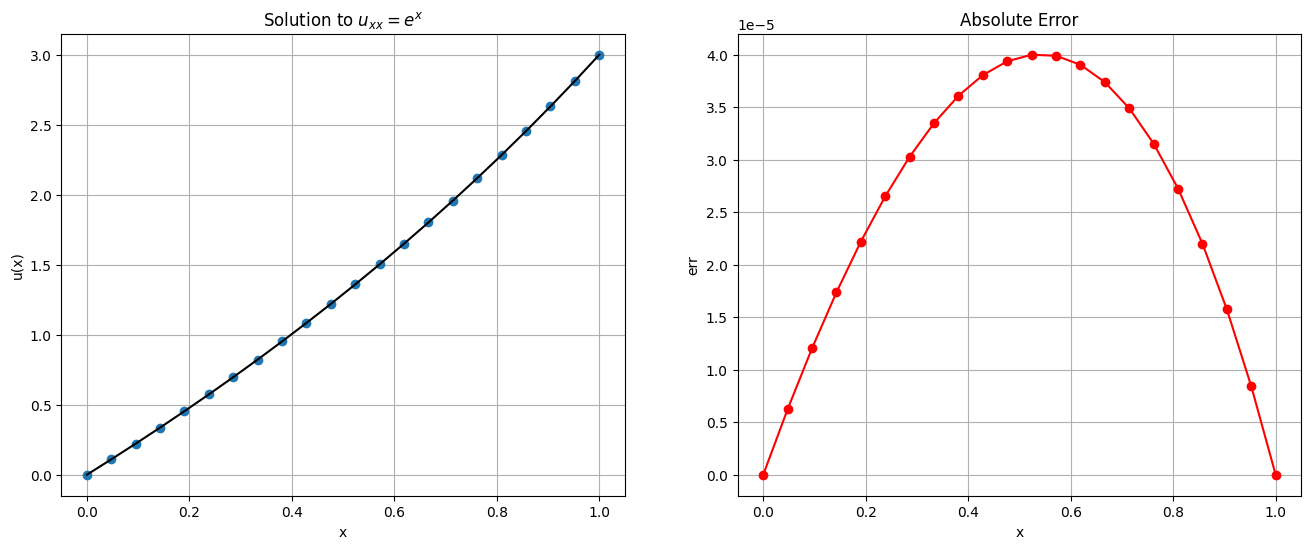

In [ ]:
# Plot result
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
axes.grid()

axes = fig.add_subplot(1, 2, 2)
err = numpy.abs(U - u_true(x_bc))
axes.plot(x_bc, err, 'ro-')
axes.set_title("Absolute Error")
axes.set_xlabel('x')
axes.set_ylabel('err')
axes.grid()
plt.show()

If we instead have Neumann boundary conditions it is no longer clear how to handle the boundary conditions using the above approach.  Instead a **ghost cell** approach is often used.  These **ghost cells** are added unknowns that represent the boundary values that we actually know.  

For instance, if we had the BVP
$$
    u_{xx} = e^x, \quad x \in [-1, 1] \quad \text{with} \quad u(-1) = 3, \text{ and } u_x(1) = -5
$$
then we could keep the boundary values in the vector of unknowns so that now
$$
    U = \begin{bmatrix} U_0 \\ U_1 \\ \vdots \\ U_N \\ U_{N+1} \end{bmatrix}
$$
where here $U_0$ and $U_{N+1}$ are actually the boundary points.  

The matrix $A$ is then modified to have the appropriate relationships.  In this case the left boundary condition leads to
$$
    A = \begin{bmatrix}
  1 &    &    &    &    &    \\
  \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} &    &    &    \\
    &  \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} &    &    \\
    & & \ddots & \ddots & \ddots
    \end{bmatrix} \quad \text{and} \quad b = \begin{bmatrix}
        u(a) \\ f(x_1) \\ f(x_2) \\ \vdots
    \end{bmatrix}
$$
which multiplied out simply gives
$$
    U_0 = u(-1) = 3.
$$

For the right boundary condition we can use the second order backward finite difference approximation for the first derivative
$$
    u_x(b) \approx \frac{3 U_{N+1} - 4 U_{N} + U_{N - 1}}{2.0 \Delta x} = -5
$$
which can be incorporated into the matrix $A$ and vector $b$ as
$$
    A =  \begin{bmatrix}
     \ddots & \ddots & \ddots &    &    \\
            & \frac{1}{\Delta x^2} &     \frac{-2}{\Delta x^2}&  \frac{1}{\Delta x^2} &    \\
            &        &      \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} \\
            &        &      \frac{1}{2 \Delta x} &  \frac{-4}{2 \Delta x} &  \frac{3}{2 \Delta x} \\
    \end{bmatrix} ~~~~ \text{and} ~~~~ b = \begin{bmatrix}
        \vdots \\ f(x_N) \\ u_x(b)
    \end{bmatrix}.
$$

All together the new system looks like
$$
    \begin{bmatrix}
     1 &    &    &    &    &    \\
     \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} &    &    &    \\
       &  \ddots & \ddots &  \ddots &    \\
       &    & \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} \\
            &        &      \frac{1}{2 \Delta x} &  \frac{-4}{2 \Delta x} &  \frac{3}{2 \Delta x} \\
    \end{bmatrix} \begin{bmatrix}
        U_0 \\ U_1 \\ \vdots \\ U_N \\ U_{N+1}
    \end{bmatrix} =
    \begin{bmatrix}
        u(a) \\ f(x_1) \\ \vdots \\ f(x_N) \\ u_x(b)
    \end{bmatrix}.
$$

### Example

Want to solve the BVP
$$
    u_{xx} = e^x, \quad x \in [-1, 1] \quad \text{with} \quad u(-1) = 3.0, \text{ and } u_x(1) = -5.0
$$
via the construction of a linear system of equations.

General Solution
$$
    u(x) = A x + B + e^x
$$

Apply Boundary conditions
\begin{align*}
    u(-1) &= -A + B + e^{-1} = 3\\
    u_x(1) &= A + e^1 = -5\\
\end{align*}

Which implies
\begin{align*}
    A &= -5 - e \\
    B & = A - e^{-1} + 3\\
\end{align*}

Which gives the Specific solution

$$
    u(x) = -(5 + e) x -(2 + e + e^{-1}) + e^{x}
$$

In [ ]:
# Problem setup
a = -1.0
b = 1.0
u_a = 3.0
u_x_b = -5.0
f = lambda x: numpy.exp(x)
u_true = lambda x: -(5.0 + numpy.exp(1.0)) * x - (2.0 + numpy.exp(1.0) + numpy.exp(-1.0)) + numpy.exp(x)

In [ ]:
# Discretization
N = 10
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Construct matrix A
A = numpy.zeros((N + 2, N + 2))
diagonal = numpy.ones(N + 2) / delta_x**2
A += numpy.diag(diagonal * -2.0, 0)
A += numpy.diag(diagonal[:-1], 1)
A += numpy.diag(diagonal[:-1], -1)

# Construct RHS
b = f(x_bc)

In [ ]:
print(A)

[[-60.5   30.25   0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.  ]
 [ 30.25 -60.5   30.25   0.     0.     0.     0.     0.     0.     0.
    0.     0.  ]
 [  0.    30.25 -60.5   30.25   0.     0.     0.     0.     0.     0.
    0.     0.  ]
 [  0.     0.    30.25 -60.5   30.25   0.     0.     0.     0.     0.
    0.     0.  ]
 [  0.     0.     0.    30.25 -60.5   30.25   0.     0.     0.     0.
    0.     0.  ]
 [  0.     0.     0.     0.    30.25 -60.5   30.25   0.     0.     0.
    0.     0.  ]
 [  0.     0.     0.     0.     0.    30.25 -60.5   30.25   0.     0.
    0.     0.  ]
 [  0.     0.     0.     0.     0.     0.    30.25 -60.5   30.25   0.
    0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.    30.25 -60.5   30.25
    0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.    30.25 -60.5
   30.25   0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.    30.25
  -60.5   30.25]
 [  0.     0.     0.     0.     0.    

In [ ]:
# Boundary conditions
A[0, 0] = 1.0
A[0, 1] = 0.0
A[-1, -1] = 3.0 / (2.0 * delta_x)
A[-1, -2] = -4.0 / (2.0 * delta_x)
A[-1, -3] = 1.0 / (2.0 * delta_x)

b[0] = u_a
b[-1] = u_x_b

In [ ]:
print(A)

[[  1.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.  ]
 [ 30.25 -60.5   30.25   0.     0.     0.     0.     0.     0.     0.
    0.     0.  ]
 [  0.    30.25 -60.5   30.25   0.     0.     0.     0.     0.     0.
    0.     0.  ]
 [  0.     0.    30.25 -60.5   30.25   0.     0.     0.     0.     0.
    0.     0.  ]
 [  0.     0.     0.    30.25 -60.5   30.25   0.     0.     0.     0.
    0.     0.  ]
 [  0.     0.     0.     0.    30.25 -60.5   30.25   0.     0.     0.
    0.     0.  ]
 [  0.     0.     0.     0.     0.    30.25 -60.5   30.25   0.     0.
    0.     0.  ]
 [  0.     0.     0.     0.     0.     0.    30.25 -60.5   30.25   0.
    0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.    30.25 -60.5   30.25
    0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.    30.25 -60.5
   30.25   0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.    30.25
  -60.5   30.25]
 [  0.     0.     0.     0.     0.    

In [ ]:
# Solve system
U = numpy.empty(N + 2)
U = numpy.linalg.solve(A, b)

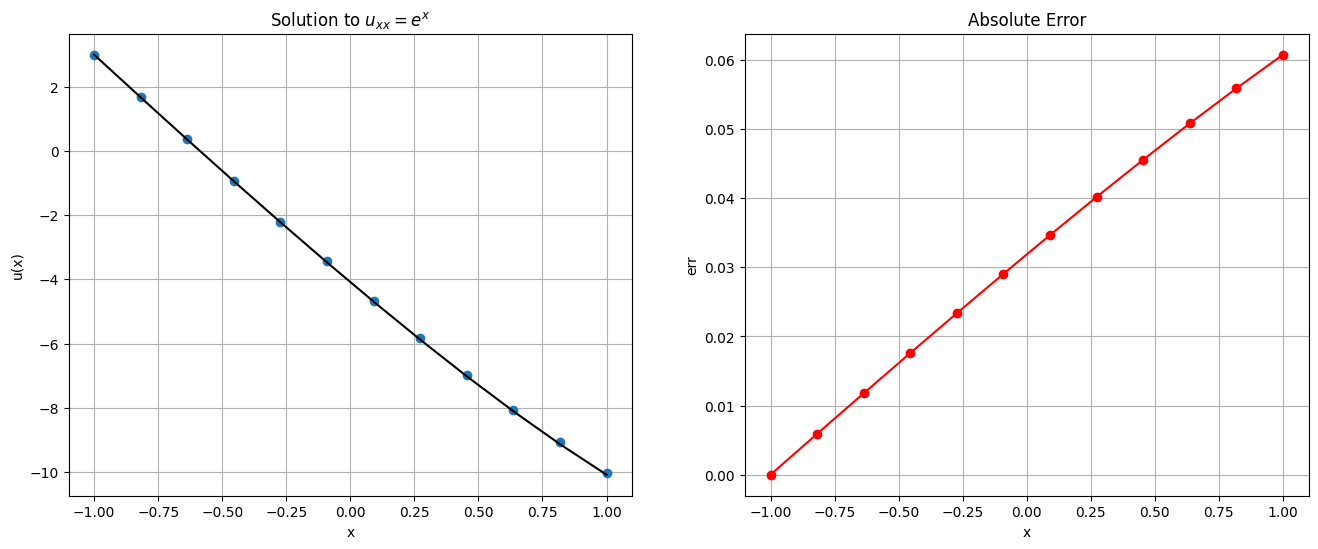

In [ ]:
# Plot result
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
axes.grid()

axes = fig.add_subplot(1, 2, 2)
err = numpy.abs(U - u_true(x_bc))
axes.plot(x_bc, err, 'ro-')
axes.set_title("Absolute Error")
axes.set_xlabel('x')
axes.set_ylabel('err')
axes.grid()
plt.show()


## Generalizations and Sparse Matrices for $A u = f$

Most finite difference approximations to linear two-point boundary value problems will  lead to large sparse linear systems of the form $A \mathbf{u} = \mathbf{f}$ where $\mathbf{u}$ is a discrete sampling of the continous function $u$ at a vector of coordinates $\mathbf{x}$ and $\mathbf{f} = f(\mathbf{x})$ is the discrete sampling of the RHS, and $A$ is a finite difference approximation to some Linear differential operator.

Using the tools we have already developed for general finite difference stencils (e.g. with the routine fdcoeffV), we can write some useful utility routines for assembly of general sparse operators.  Here we will use a combination of `fdcoeffV` and `scipy.sparse` to assemble general sparse matrices for the second derivative operator on an arbitrary mesh with a choice of consistent dirichlet or Neumann BC's

In [ ]:
from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity
from scipy.sparse.linalg import spsolve

ModuleNotFoundError: No module named 'fdcoeffV'

In [ ]:
def D2(x,bcs=['dirichlet', 'dirichlet']):
    """
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs

        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))

    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))

    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )
    return A.tocsr()

def RHS(x, f, bvalues):
    """ Set the rhs vector

        parameters
        ----------
        x: numpy.array
            mesh coordinates
        f: callable
            rhs function for interior points called on f(x[1:-2])
        bvalues:  numpy.array (len 2)
            values for boundary conditions (either dirichlet or neumann)
    """

    N = len(x)
    rhs = numpy.empty(N)
    rhs[[0, N-1]] = bvalues
    rhs[1:-1] = f(x[1:-1])

    return rhs


In [ ]:
# check our routines for a small mesh
x = numpy.linspace(0,1,5)
print('x = {}'.format(x))
print()
A = D2(x,['dirichlet','neumann'])
print('A = \n{}'.format(A.todense()))

In [ ]:
print(A)

In [ ]:
fig = plt.figure(figsize=(6,6))
axes = fig.add_subplot(1,1,1)
axes.spy(A)
axes.grid()
axes.set_title('Visualization of Sparse Matrices')
plt.show()

In [ ]:
b = RHS(x, numpy.exp, [1.,1.])
print(b)

### Now let's solve our previous problem again

$$
    u_{xx} = e^x \quad u(0) = 0.,\quad u(1) = 3.0
$$

on a regular mesh with 100 points

In [ ]:
N = 10
a = 0.
b = 1.
x = numpy.linspace(a, b, N)

A = D2(x)
f = RHS(x, numpy.exp, [0., 3. ])

u = spsolve(A,f)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

In [ ]:
# Plot result
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(x, u, 'o', label="Computed")
axes.plot(x, u_true(x), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
axes.grid()

axes = fig.add_subplot(1, 2, 2)
err = numpy.abs(u - u_true(x))
axes.plot(x, err, 'ro-')
axes.set_title("Absolute Error")
axes.set_xlabel('x')
axes.set_ylabel('err')
axes.grid()
plt.show()


### And Check convergence

From our discussion of finite differences, our current discrete operator should have errors that scale as $O(\Delta x^2)$.  We can easily check that.

In [ ]:
N = [ 2**n for n in range(3,9) ]
rel_err = numpy.empty(len(N))
delta_x = numpy.empty(len(N))

for i,n in enumerate(N):
    x = numpy.linspace(a, b, n)
    A = D2(x)
    f = RHS(x, numpy.exp, [0., 3. ])
    u = spsolve(A,f)
    rel_err[i] = numpy.linalg.norm(u - u_true(x))/numpy.linalg.norm(u_true(x))
    delta_x[i] = x[1] - x[0]


In [ ]:
# calculate best fit slope and Plot result
p = numpy.polyfit(numpy.log(delta_x),numpy.log(rel_err),1)
dx = numpy.logspace(numpy.log10(delta_x[0]),numpy.log10(delta_x[-1]),100)
err = numpy.exp(p[1])*dx**p[0]
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, rel_err, 'o',label='error', markersize=10 )
axes.loglog(dx,err,'r--',label="p={}".format(p[0]))
axes.set_title("Convergence")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$||u - u_{true}||/||u_{true}||$")
axes.legend(loc='best')
axes.grid()

### An exercise:

Use these tools to try and  solve a more interesting two-point linear  BVP

$$
    u_{xx} + 4u = x , \quad\quad u(0) = 0,  u(2\pi) = 0
$$

## Finite Difference methods for non-linear problems


Suppose we wanted to solve our original non-linear 2-pt BVP
$$
    u_{xx} + \sin{u} = 0 , \quad\quad u(0) = 0,  u(2) = \frac{\pi}{2}
$$

Using finite difference methods...How would you go about setting up and solving this problem?

If we first replace our continuous function $u$ with its discrete approximation

$$
    \mathbf{u} = u(\mathbf{x})
$$

where $\mathbf{x}$ is a vector of coordinates in $\mathbb{R}^n$

we can approximate the second derivative operator using finite differences
$$
    u_{xx} \approx D\mathbf{u}
$$

then our initial ODE becomes the discrete **Non-linear** problem

$$
    D\mathbf{u} + \sin(\mathbf{u}) = \mathbf{0} \quad u_0 = 0,\, u_N = \frac{\pi}{2}
$$

or more succinctly

$$
    \mathbf{F}(\mathbf{u}) = \mathbf{0}
$$

which can be attacked with a Newton solver, Given an appropriate Jacobian.

We have already discussed that for a linear problem with

$$
    \mathbf{F}(\mathbf{u}) =  A\mathbf{u} -\mathbf{b}
$$

 each equation in the residual can be written as

$$
    F_i(\mathbf{u}) = \sum_j a_{ij}u_j - b_i
$$

Therefore the Jacobian is simply
$$
    J_{ij} = \frac{\partial F_i}{\partial u_j} =a_{ij}
$$

or

$$
    J = A
$$

For our non-linear residual

$$
  \mathbf{F}(\mathbf{u}) =   D\mathbf{u} + \sin(\mathbf{u}) = \mathbf{0}
$$

each equation can be written

$$
    F_i(\mathbf{u}) = \sum_j D_{ij}u_j  +\sin(u_i) = 0
$$

or
$$
    F_i(\mathbf{u}) = \sum_j \left[ D_{ij}u_j  +\delta_{ij}\sin(u_j)\right] = 0
$$

where $\delta_{ij}$ is the kronecker delta

which suggests that the Jacobian is just

$$
    J_{ij}(\mathbf{u})=  D_{ij}  +\delta_{ij}\cos(u_j) = 0
$$

or

$$
    J(\mathbf{u}) = D +\mathrm{diag}(\cos(\mathbf{u}))
$$

which we should be able to hand off to a Newton solver.

### Question?

How to handle Boundary conditions?

### Let's code this up

In [ ]:
# We'll need to describe a sparse diagonal matrix and a sparse solver
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

# and a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations

    Params:
    -------
        F: calleable:
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration

    Returns:
    --------
        x: list
            list of points for each Newton iteration (just used for plotting intermediate results)
            the solution is x[-1]
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS

    """
    x = [ x0 ]
    for k in range(MAX_ITS+1):
        xk = x[k]
        res = numpy.linalg.norm(F(xk))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol:
            return numpy.array(x), k
        delta = spsolve(J(xk),-F(xk))
        x.append( xk + delta)



    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))




In [ ]:
# test on a linear problem

N = 20
x = numpy.linspace(0.,1.,N)
A = D2(x)
# set the residual with 0 dirichlet condtions
def F(u):
    f =  A.dot(u) - numpy.exp(x)
    # set residual to 0 on dirichlet BCs
    f[[0,-1]] = 0
    return f

# set the jacobian
def J(u):
    return A


# initial guess use a straight line with the correct boundary conditions

u0 = numpy.linspace(0.,3.,N)
sol,its = newton(F,J,u0)

In [ ]:
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1,2,1)
for k in range(its+1):
    axes.plot(x,sol[k],label='$k={}$'.format(k))
axes.plot(x,u_true(x),'k--',label='$u_{true}$')
axes.grid()
axes.legend(loc='best')
axes.set_xlabel('x')
axes.set_ylabel('u')


axes = fig.add_subplot(1, 2, 2)
err = numpy.abs(sol[-1] - u_true(x))
axes.plot(x, err, 'ro-')
axes.set_title("Absolute Error")
axes.set_xlabel('x')
axes.set_ylabel('err')
axes.grid()
plt.show()

plt.show()

In [ ]:
# test on a non-linear problem

N = 20
x = numpy.linspace(0.,2.,N)
A = D2(x)
# set the residual with 0 dirichlet condtions
def F(u):
    f =  A.dot(u) + numpy.sin(u)
    # set residual to 0 on dirichlet BCs
    f[[0,-1]] = 0
    return f

# set the jacobian
def J(u):
    n = len(u)
    return A + spdiags(numpy.cos(u),0,n,n)


# initial guess use a straight line with the correct boundary conditions

u0 = numpy.linspace(0.,numpy.pi/2,N)
sol,its = newton(F,J,u0)

In [ ]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
for k in range(its+1):
    axes.plot(x,sol[k],label='$k={}$'.format(k))
axes.grid()
axes.legend(loc='best')
axes.set_xlabel('x')
axes.set_ylabel('u')
plt.show()

# Introduction to Finite Element methods

In the previous problem we used Finite Difference methods to transform linear and non-linear continous ODE's into discrete linear or non-linear problems of form $A\mathbf{u} = \mathbf{f}$ or $\mathbf{F}(\mathbf{u}) = \mathbf{0}$ which we can solve with standard linear and non-linear solvers.

Finite Element Methods (FEM),  will, in the end,  accomplish the same thing,  mapping from a continous, infinite dimensional problem to a finite dimensional problem, but in a mathematically more satisfying approach

## Outline

* Finite Dimensional Function Spaces (piecewise linear functions)
* Bases for Function spaces (the hat functions)
* Global Basis vs Element Basis
* Galerkin Projection as a least-squares problem
    * Review of Linear Least Squares
    * The Projection problem
    * The Mass Matrix and Load vector


### Piecewise Polynomial Function Spaces

In our discussion of interpolation, we introduced the idea of a piecewise polynomial interpolation and illustrated it with a **Piecewise Linear**  "connect-the-dots" function defined on a set of nodes on the interval $x\in[0,L]$

In [ ]:
nodes = numpy.array([ 0., 2.,  4.,  6.,  7.,  9., 10.        ])
f = numpy.array( [0.5 ,  1.5, 2.0, 3., 2.75 , 1.,  0.5])


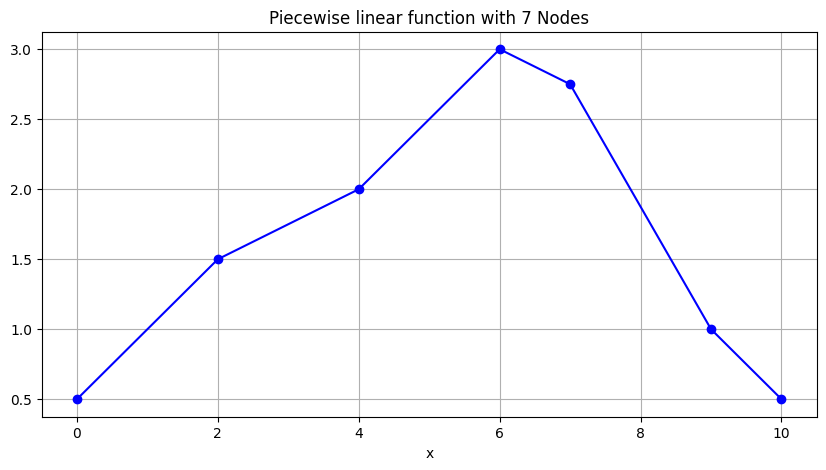

In [ ]:
L=10
#x = numpy.linspace(0,L,N)
#x[1:-1] += numpy.random.rand(N-2)
#f = .1*(x*(L - x) + numpy.random.rand(N))
#nodes = numpy.array([ 0., 2.07005551,  4.30576527,  5.70618816,  6.72033573,  9.30961848, 10.        ])
#f = numpy.array( [0.5595035,  1.72355142, 2.52531147, 2.49691638, 2.24858267, 0.73643982,  0.02774723])
N = len(nodes)

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(nodes,f,'bo-')
axes.set_xlabel('x')
axes.set_title('Piecewise linear function with {} Nodes'.format(N))
axes.grid()

#%precision 3
#print('nodes  = {}'.format(nodes))
#print('values = {}'.format(f))

#### Points:

* The function is continuous $f(x)\in C^0$ and defined for all $x\in[0,L]$
* However, it is defined by only 7 points
* **All** piecewise linear functions on this mesh form a **Function Space** that is isomorphic to  $\mathbb{R}^7$

In [ ]:
# define the hat functions
def hats(x, nodes):
    """ mainly for pedagogy, calculate the hat functions given a set of nodes """
    N = len(nodes)
    l0 = lambda x, x0, x1: (x - x1)/(x0 - x1)
    l1 = lambda x, x0, x1: (x - x0)/(x1 - x0)

    phi = numpy.zeros((N, len(x)))
    conds = [x <= nodes[1], x >= nodes[1]]
    phi[0] = numpy.piecewise(x, conds, [ lambda x: l0(x, nodes[0], nodes[1]),  lambda x: 0.])
    for i in range(1,N-1):
        conds = [x < nodes[i-1], (x >= nodes[i-1]) & (x <= nodes[i]), (x >= nodes[i]) & (x <= nodes[i+1]), x >= nodes[i+1]]
        funcs = [ lambda x: 0., lambda x: l1(x,nodes[i-1],nodes[i]), lambda x: l0(x,nodes[i],nodes[i+1]), lambda x: 0.]
        phi[i] = numpy.piecewise(x,conds,funcs)

    conds = [x <= nodes[-2], x >= nodes[-2]]
    phi[-1] = numpy.piecewise(x, conds, [   lambda x: 0., lambda x: l1(x, nodes[-2], nodes[-1])])
    return phi


### The Hat functions:  A basis for piecewise linear functions

As any vector in $\mathbb{R}^7$ can  be describe uniquely given 7 linearly independent **basis vectors**,  any piecewise-linear function in this function space can be described uniquely  given a linearly independent set of **basis functions**.

A useful basis for a piecewise linear function are the global "hat" functions which are piecewise linear functions defined such that $\phi_i =1$ at node $i$ and is 0 at all other nodes.

This figure shows two hat functions, $\phi_2$ and $\phi_3$ which control the functions at points 2 and 3 respectively

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-4288946648.py:7: SyntaxWarning: invalid escape sequence '\p'
  axes.plot(x,phi[2],'r',label='$\phi_2$')
/tmp/ipython-input-4288946648.py:8: SyntaxWarning: invalid escape sequence '\p'
  axes.plot(x,phi[3],'c--',label='$\phi_3$')


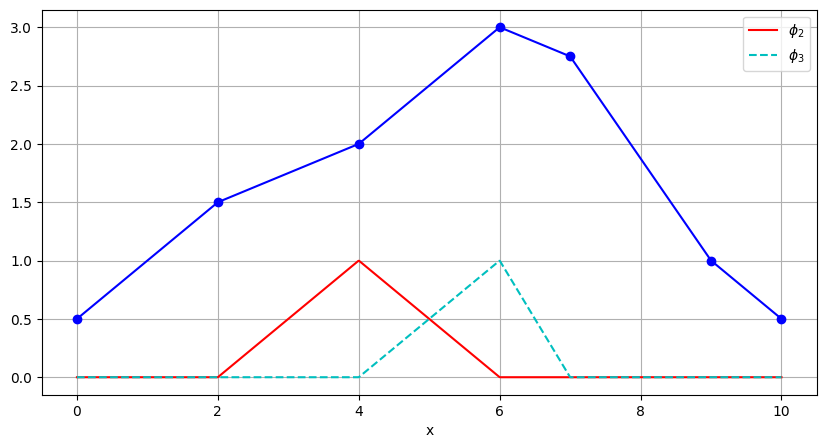

In [ ]:
x = numpy.linspace(0.,L,1000)
phi = hats(x,nodes)

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(nodes,f,'bo-')
axes.plot(x,phi[2],'r',label='$\phi_2$')
axes.plot(x,phi[3],'c--',label='$\phi_3$')
#axes.plot(x,phi[5],'g--',label='$\phi_5$')
axes.set_xlabel('x')
axes.legend()
axes.grid()
plt.show()

All 7 Hat Functions for this particular mesh

<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1368171207.py:8: SyntaxWarning: invalid escape sequence '\p'
  axes.plot(x,phi[i],label='$\phi_{}$'.format(i))


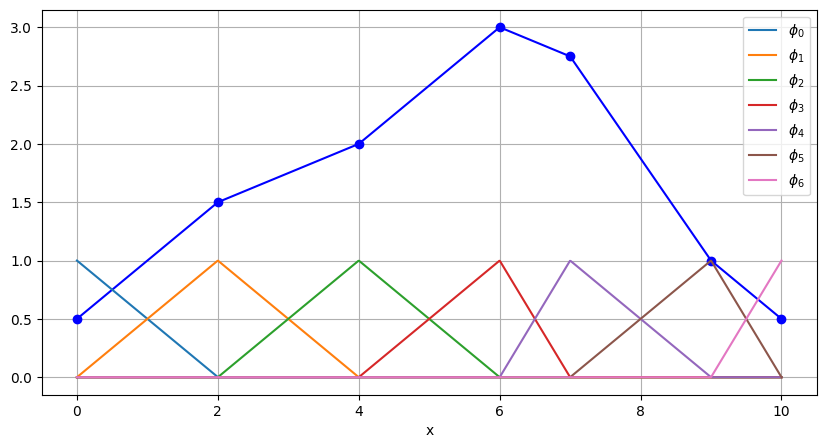

In [ ]:
x = numpy.linspace(0.,L,1000)
phi = hats(x,nodes)

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(nodes,f,'bo-')
for i in range(phi.shape[0]):
   axes.plot(x,phi[i],label='$\phi_{}$'.format(i))
axes.set_xlabel('x')
axes.legend()
axes.grid()
plt.show()

Note:  for each linear segment between two nodes,  the pieces of adjacent hat functions are just the linear Lagrange polynomials defined over that segment.

Given a basis for the space of all piecewise linear functions on a given mesh.  We can now write any function in this space as a linear combination of the basis functions
i.e.
$$
    \tilde{f}(x) = \sum_j^N w_j \phi_j(x)
$$

where $w_j$ is a weight.  It should be clear that due to the properties of the hat functions.  

$$
    \tilde{f}(x_i) = \sum_j^N w_j \phi_j(x_i) = \sum_j^N w_j \delta_{ij} = w_i
$$
and the weights are just the value of the function at node $j$

In [ ]:
w = f.copy()
print(w)
phi = hats(x,nodes)


In [ ]:
w_star = w.copy()
w_star[3] = 0.5*w[3]
func = w_star.dot(phi)

In [ ]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(nodes,f,'bo--',label='$f(x)$')
axes.plot(x, func,'g-',label='$f^*(x)$')
axes.plot(x,phi[2],'r',label='$\phi_2$')
axes.plot(x,phi[3],'c--',label='$\phi_2$')
#axes.plot(x,phi[5],'g--',label='$\phi_5$')
axes.set_xlabel('x')
axes.legend()
axes.grid()
plt.show()


### The element view

This may all feel a little familiar and may become clearer if we consider just the element between nodes 2 and 3

In [ ]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(nodes,f,'bo--',label='$f(x)$')
#axes.plot(x, func,'g-',label='$f^*(x)$')
axes.plot(x,phi[2],'r',label='$\phi_2$')
axes.plot(x,phi[3],'c--',label='$\phi_3$')
axes.plot(nodes[2]*numpy.ones(2),[0.,f[2]],'g',linewidth=3)
axes.plot(nodes[3]*numpy.ones(2),[0.,f[3]],'g',linewidth=3)
#axes.plot(x,phi[5],'g--',label='$\phi_5$')
axes.set_xlabel('x')
axes.legend()
axes.grid()
plt.show()

For a single element it should be come clear, that the hat functions are just the lagrange polynomials for linear interpolation within element 2. And we can define local basis functions for each element $N_1$ and $N_2$

### Interpolation of a function $f(x)$ onto $P_1$

Given a set of elements and a local interpolant,  the hat functions form a basis for the space $\cal V$ of all Piecewise linear functions on the mesh.  If the interpolant is Linear and continuous we call this space $P_1$ and all functions $\tilde f$ in $P_1$ can be written as

$$
    \tilde{f}(x) = \sum_j w_j\phi_j(x)
$$

where $\phi_j(x)$ is the $j$th basis (hat) function.

To *interpolate* a continuous function $f(x)$ onto $P_1$, we simply require that
$$
    \tilde{f}(x_i) = f(x_i)
$$

i.e the interpolant agrees with the function at each node.  It's not hard to see that in this case

$$
    w_i = f(x_i)
$$
and the weights are just the value of the function at the nodes.

### Example

let $f(x) =\sin{\pi x}$

In [ ]:
x = numpy.linspace(0,L)
f = lambda x: numpy.sin(x)
w = f(nodes)
phi = hats(x,nodes)
ftilde = w.dot(phi)

In [ ]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(x,f(x),'b-',label='$f(x)$')
axes.plot(x,ftilde,'r--',label='$\\tilde{f}(x)$')
axes.plot(nodes,w,'ro')
axes.set_xlabel('x')
axes.legend()
axes.grid()
plt.show()


### Galerkin Projection of  a function $f(x)$ onto $P_1$

Given a function and its interpolant (or any other function in  $P_1$), we can consider their difference

$$
    r(x) = f(x) - \tilde{f}(x)
$$

which is a function of $x$ we call the residual.  

In [ ]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(x,f(x),'b-',label='$f(x)$')
axes.plot(x,ftilde,'r--',label='$\\tilde{f}(x)$')
axes.plot(x,f(x)-ftilde,'g:', label='$r(x)$')
axes.plot(nodes,w,'ro')
axes.set_xlabel('x')
axes.legend()
axes.grid()
plt.show()


The **projection** of $f$ onto $P_1$ is a different function $f_h$ defined as the function in $P_1$ that minimizes the residual in a least squares sense, i.e.

find $f_h\in P_1$ that minimizes the $L_2$ norm

$$
    || f(x) - f_h(x) ||^2 = \int_\Omega ( f(x) - f_h(x))^2 dx
$$

where $\Omega$ is the domain, in this case $x\in[0,L]$

This problem is reminiscent of the Linear least squares problem for an overdetermined problem

$$
    A\mathbf{x} = \mathbf{b}
$$

for $A\in\mathbb{R}^{m\times n}$, $\mathbf{x}\in\mathbb{R}^n$ $\mathbf{b}\in\mathbb{R}^m$ with $m>n$

where we want to find $\hat{\mathbf{x}}$ that minimizes  the Euclidean norm of the residual $\mathbf{r} = A\mathbf{\hat{x}} - \mathbf{b}$, where $A\mathbf{\hat{x}}=\mathbf{p}$ is the *projection* of $\mathbf{b}$ onto the column space of $A$

We will review that problem first, as if you understand classical linear least-squares it is easy to understand Galerkin projection onto a finite-dimensional function space.

### Review:  Orthogonal projection and Least-Squares Problems

Consider the overdetermined problem $A\mathbf{x}=\mathbf{b}$ where $A\in\mathbb{R}^{3\times2}$ and $\mathbf{b}\in\mathbb{R}^3$ i.e.

$$
    \begin{bmatrix} | & | \\
                    \mathbf{a}_1 & \mathbf{a}_2\\
                     | & | \\
     \end{bmatrix} \begin{bmatrix} x_1 \\ x_2\\ \end{bmatrix}
         = \begin{bmatrix} |   \\
                    \mathbf{b} \\
                     |  \\
                     \end{bmatrix}
$$

and $\mathbf{a}_1$, $\mathbf{a}_2$ are linearly independent vectors that span a two-dimensional subspace of $\mathbb{R}^3$.         

**Geometrically** this problem looks like

<img align=center, src="https://github.com/D-Mayerfeld/intro-numerical-methods/blob/master/images/least_squares_geometry.jpg?raw=1" alt="Drawing" width=600/>



If $\mathbf{b}\notin C(A)$, then there is clearly no solution to $A\mathbf{x}=\mathbf{b}$.  However, we can find the point $\mathbf{p}=A\hat{\mathbf{x}}\in C(A)$ that minimizes the length of the the error $\mathbf{e}=\mathbf{b}-\mathbf{p}$.  While we could resort to calculus to find the values of $\hat{\mathbf{x}}$ that minimizes $||\mathbf{e}||_2$.  It should be clear from the figure that the shortest error (in the $\ell_2$ norm) is the one that is perpendicular to every vector in $C(A)$.  

To be orthogonal to every vector in $C(A)$ only requires that the error is orthogonal to each basis vector. i.e.

$$
     \mathbf{a}_i^T\mathbf{e} =0, \quad  i=1,2
$$

Which is equivalent to saying

$$
    A^T\mathbf{e} = \begin{bmatrix} - & \mathbf{a}_1^T & - \\
                                    - & \mathbf{a}_2^T & - \\ \end{bmatrix}\mathbf{e} =  \mathbf{0}
$$
(or that the error must be in the left-Null Space $N(A^T)$)

This implies
\begin{align}
    \mathbf{0} &= A^T\mathbf{e} \\
    &= A^T(\mathbf{b}-\mathbf{p})\\
    &= A^T(\mathbf{b} - A\hat{\mathbf{x}})\\
\end{align}

or we just need to solve the "Normal Equations"  
$$ A^T A\hat{\mathbf{x}} = A^T\mathbf{b}$$

for the least-squares solution $\hat{\mathbf{x}}$  


and the **projection** $\mathbf{p}$ of $\mathbf{b}$ onto $C(A)$ is just

$$
    \mathbf{p}= A\hat{\mathbf{x}}
$$

While this problem can be solved using calculus,  the better approach is to use linear algebra to find a residual that is orthogonal to $C(A)$, i.e. is orthogonal to all the columns of $A$.  In essence, the smallest residual will be the one that cannot be constructed out of any of the basis vectors of $A$.   (see Lecture Notes `11_LA_QR.ipynb` for more details)

The Galerkin projection of a function onto a finite-dimensional functions space can be found by essentially the same process if we extend the definition of orthogonality and the dot product.

For vectors in $\mathbb{R}^n$ the inner product is just the dot product i.e.

$$
    <\mathbf{x},\mathbf{y}> = \mathbf{x}^T\mathbf{y}
$$  

with Euclidean norm

$$
    ||\mathbf{x}||^2 = <\mathbf{x},\mathbf{x}>
$$

Moreover we consider two vectors $\mathbf{x}$ and $\mathbf{y}$ to be **orthogonal** when

$$<\mathbf{x},\mathbf{y}> = 0$$

Likewise we can define the $L_2$ inner product for functions as

$$
    <f, g> = \int_\Omega f(x)g(x)dx
$$

with norm

$$
    ||f||^2_{L_2} = <f,f>
$$

and orthogonality of functions whenever $<f,g>=0$

Then it becomes straightforward to construct the problem to solve for the Galerkin projection of $f(x)$ onto $P_1$

Given a finite dimensional function space $\cal V$ (e.g. $P_1$) with basis functions

$$
    \phi_0(x),\phi_2(x),\ldots,\phi_N(x)
$$

Then any function in $\cal V$ can be written as
$$
    f_h(x) = \sum_{j=0}^N w_j\phi_j(x)
$$

if we also let $f(x)$ be any continuous function (not necessarily in $\cal V$) then we can define the residual as

$$
    r(x) = f_h(x) - f(x)
$$

to find the smallest residual, we seek $f_h(x)$ such that $r(x)$ is orthogonal to all the basis functions, i.e.

find $\mathbf{w}$ such that

$$
    <\phi_i, r(x)> = 0 \quad\forall\, i=0,\ldots N
$$

or

$$
    \int_\Omega \phi_i\left[\sum_j w_j\phi_j(x)- f(x)\right]dx = 0, \quad \forall\, i=0,\ldots N
$$

or rearranging,   solve for the $w_j$ such that

$$
    \int_\Omega \phi_i\sum_j w_j\phi_j(x)dx = \int_\Omega f\phi_i dx,  \quad \forall\, i=0,\ldots N
$$

Now the first term of
$$
    \int_\Omega \phi_i\sum_j w_j\phi_j dx = \int_\Omega f\phi_i dx,  \quad \forall\, i=0,\ldots N
$$

can be re-arranged to swap the sum and the integral to get

$$
    \sum_j \left[ \int_\Omega \phi_i\phi_j dx\right]w_j = \int_\Omega f\phi_i dx,  \quad \forall\, i=0,\ldots N
$$

or
$$
    \sum_j <\phi_i,\phi_j> w_j = <f,\phi_i>  \quad \forall\, i=0,\ldots N
$$

or
$$
    \sum_j <\phi_i,\phi_j> w_j = <f,\phi_i>  \quad \forall\, i=0,\ldots N
$$or letting
$$
    M_{ij} = <\phi_i,\phi_j>,\quad f_i = <f, \phi_i>
$$

the problem reduces to a linear algebra problem $M\mathbf{w} = \mathbf{f}$ where $M$ is the **Mass Matrix** and $\mathbf{f}$ is the **load vector**

### Assembling the Mass Matrix and load vector

if $\phi_i$ are the hat functions,  it's not hard to see that the Mass Matrix should be tridiagonal as the only hat functions that should interact around node $i$ should be $\phi_{i-1}$, $\phi_i$, $\phi_{i+1}$.



In [ ]:
x = numpy.linspace(0,L,500)
phi = hats(x,nodes)

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(x,phi[2],'g--',label='$\phi_{i-1}$')
axes.plot(x,phi[3],'r-',label='$\phi_i$')
axes.plot(x,phi[4],'b--',label='$\phi_{i+1}$')


#axes.plot(x,phi[5],'g--',label='$\phi_5$')
axes.set_xlabel('x')
axes.legend()
axes.grid()
plt.show()


i.e.  in the above picture, it should be clear that $<\phi_{i-1}, \phi_{i+1} > = 0$.  So that for the $i$th row of $M$,  the only three values should be

$$<\phi_{i-1},\phi_i>,\, <\phi_{i},\phi_i>,\, <\phi_{i},\phi_{i+1}>$$

### Assembling the Element tensor

It is possible to calculuate the terms of the global mass matrix directly from the hat functions.  However, this can be cumbersome due to the piecewise nature of the hat functions $\phi_i(x)$.  The standard approach is to loop over elements, and just calculate the contribution from each element.  

In [ ]:
x = numpy.linspace(0,L,500)
phi = hats(x,nodes)

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(x,phi[2],'g--',label='$\phi_{2}$')
axes.plot(x,phi[3],'r-',label='$\phi_3$')
axes.plot(x,phi[4],'b--',label='$\phi_4$')
for node in nodes:
    axes.plot(node*numpy.ones(2),[0.,1],'k:',linewidth=2)
for i in range(len(nodes)-1):
    axes.text(0.5*(nodes[i+1]+nodes[i])-.06, 0.1, '$e_{}$'.format(i),size=16)

axes.plot(nodes[2]*numpy.ones(2),[0.,1],'m-.',linewidth=3)
axes.plot(nodes[3]*numpy.ones(2),[0.,1],'m-.',linewidth=3)


#axes.plot(x,phi[5],'g--',label='$\phi_5$')
axes.set_xlabel('x')
axes.legend(loc='best')
#axes.grid()
plt.show()


For example.  Element $e_2$,  will contribute to 4 entries in the global Mass matrix.

For row $i=2$ (for $\phi_2$), it will contribute part of $<\phi_2,\phi_2>$ and all of $<\phi_2,\phi_3>$.

For row $i=3$ (for $\phi_3$), it will contribute all of $<\phi_2,\phi_3>$ and part of $<\phi_3,\phi_3>$

### Assembling the Element tensor

For each element we can define local basis Functions $N_1$ and $N_2$ which are just the degree 1 Lagrange polynomials for the linear interpolant over element $i$.

In [ ]:
x = numpy.linspace(0,L,500)
phi = hats(x,nodes)

N1 = lambda t: (1 - t)/2.
N2 = lambda t: (1 + t)/2.

# affine transformation of element
xt = lambda t, coords: coords[0] + (coords[1] - coords[0]) * (t + 1)/2

t = numpy.linspace(-1,1)

coords = nodes[2:4]

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(xt(t,coords),N1(t),'g--',label='$N_1$')
axes.plot(xt(t,coords),N2(t),'r-',label='$N_2$')
axes.plot(x,numpy.zeros(x.size),'k')
for node in nodes:
    axes.plot(node*numpy.ones(2),[0.,1],'k:',linewidth=2)
for i in range(len(nodes)-1):
    axes.text(0.5*(nodes[i+1]+nodes[i])-.06, 0.1, '$e_{}$'.format(i),size=16)

axes.plot(nodes[2]*numpy.ones(2),[0.,1],'m-.',linewidth=3)
axes.plot(nodes[3]*numpy.ones(2),[0.,1],'m-.',linewidth=3)


#axes.plot(x,phi[5],'g--',label='$\phi_5$')
axes.set_xlabel('x')
axes.legend(loc='best')
#axes.grid()
plt.show()


Within Element $e_2$ we can construct an *element Mass Matrix* and *element load vector*

$$
    M^e_2 = \begin{bmatrix} <N_1,N_1> & <N_1, N_2> \\ <N_1, N_2> & <N_2, N_2> \\ \end{bmatrix}\quad
    f^e_2 = \begin{bmatrix} <N_1, f> \\  <N_2, f> \\ \end{bmatrix}
$$

where each of the definite integrals in the inner product can be evaluated either analytically or usually using quadrature

### Assembling the Global tensors

Given each element tensor,  they can then be *added* to the global Mass Matrix and load vector, to assemble the whole system.  In particular, for this problem,  the element mass matrices form overlapping diagonal blocks in $M$.

In [ ]:
Me = numpy.ones((2,2))
fe = numpy.ones(2)

N = 7

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['s', 'o', '^', 'P', '*', 'v', 'd']



fig = plt.figure(figsize=(13,6))
axes = fig.add_subplot(1,2,1)
for i in range(N-1):
    M = lil_matrix((N,N))
    M[i:i+2,i:i+2] = Me
    axes.spy(M,marker=markers[i],color=colors[i])
    axes.text(i+.4,i+.6,'$M^e_{}$'.format(i))
axes.grid()

axes = fig.add_subplot(1,2,2)
for i in range(N-1):
    f = lil_matrix((N,1))
    f[i:i+2] = fe
    axes.spy(f,marker=markers[i],color=colors[i])
    axes.text(-.1,i+.6,'$f^e_{}$'.format(i))



plt.show()


Here is some code that assemble both element tensors (using GL quadrature for the integrals in the inner products) and the global tensors

In [ ]:
def element_tensors(f, coords):
    """ returns element mass matrix and load vector for P1 elements using 2-point Gauss-Legendre quadrature rules

    parameters
    ----------
    f: calleable
        RHS function
    coords: ndarray
        x coordinates of element
    """
    # element basis functions (lagrange polynomials on [-1,1])
    N1 = lambda t: (1 - t)/2.
    N2 = lambda t: (1 + t)/2.

    # 2-pt GL points and weights
    tQ = numpy.array([-1., 1.])/numpy.sqrt(3)
    wQ = numpy.ones(2)

    # element width
    h = coords[1] - coords[0]

    # affine transformation of element
    x = lambda t: coords[0] + h * (t + 1)/2

    # element mass matrix
    Me = numpy.empty((2,2))
    Me[0, 0] = wQ.dot(N1(tQ)*N1(tQ))
    Me[0, 1] = wQ.dot(N1(tQ)*N2(tQ))
    Me[1, 0] = Me[0, 1]
    Me[1, 1] = wQ.dot(N2(tQ)*N2(tQ))
    Me *= h/2.

    # load vector

    fe = numpy.empty(2)
    fe[0] = wQ.dot(f(x(tQ))*N1(tQ))
    fe[1] = wQ.dot(f(x(tQ))*N2(tQ))
    fe *= h/2.

    return Me, fe


def assemble_global(func,nodes):
    """ Assemble the global Mass Matrix and load vector given a P1 mesh with coordinates at nodes

    parameters
    -----------
    func: calleable
        RHS function
    nodes: ndarray
        x coordinates of mesh
    """
    # number of nodes and elements
    N = len(nodes)
    Nel = N - 1

    # allocate sparse matrix and vector
    M = lil_matrix((N,N))
    f = numpy.zeros(N)

    # loop over elements and assemble global matrix
    for k in range(Nel):
        Me, fe = element_tensors(func,nodes[k:k+2])
        M[k:k+2,k:k+2] += Me
        f[k:k+2] += fe

    return M.tocsr(), f


### Solve the projection problem

again on the same mesh use $f = \sin(x)$ but find the projection $f_h$

In [ ]:
N=11
x = numpy.linspace(0., L, 100)
nodes = numpy.linspace(0.,L, N)
phi = hats(x, nodes)

func = lambda x: numpy.sin(x)
M, f = assemble_global(func,nodes)
w = spsolve(M,f)

In [ ]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(x,func(x),'b-',label='$f(x)$')
axes.plot(x,w.dot(phi),'r--',label='$f_h(x)$')
axes.plot(x,func(nodes).dot(phi),'g:',label='$\\tilde{f}(x)$')
axes.plot(nodes,w,'ro')
axes.set_xlabel('x')
axes.legend()
axes.grid()
plt.show()



## Convergence Analysis

Beyond just finding the least squares solution,  there are some important convergence results that can also be shown. (e.g. see __[Larson and Bengzon, "The Finite Element Method"](https://link.springer.com/book/10.1007/978-3-642-33287-6)__ for more details)

### Theorem 1: Best approximation

The $L^2$-projection $f_h$, satisfies the best approximation result

$$
    || f - f_h ||_{L^2} \leq || f - v ||_{L^2},\ \ \forall v \in V_h
$$

where $V_h$ is the finite element function space with basis $\phi_1, \phi_2,\ldots,\phi_N$

**Proof** from __[Larson and Bengzon Ch 1.3.4](https://link.springer.com/book/10.1007/978-3-642-33287-6)__

Let

$$
    f - f_h = f-v + v- f_h
$$

for any $v\in V_h$.  Then by definition of the $L^2$ norm on the interval $I$

$$
\begin{align}
    || f - f_h||^2_{L^2(I)} &= \int_I (f - f_h)(f-v + v- f_h)dx \\
                            &= \int_I (f - f_h)(f-v)dx +  \int_I (f - f_h)(v- f_h)dx \\
                            &= \int_I (f - f_h)(f-v)dx \\
                            &\leq || f-f_h||_{L^2(I)} ||f - v||_{L^2(I)}
\end{align}
$$

by the orthogonality of the residual to the Finite element space $V_h$ and the Cauchy-Schwarz inequality for inner products.

Dividing both sides by $|| f-f_h||_{L^2(I)}$ completes the proof which says the residual with respect to the Galerkin projection is smaller than for any other test function $v\in V_h$

### Theorem 2:  Convergence

for $V_h=P_1$, the space of all piecewise linear polynomial spaces, then an *a priori* error estimate can be found such that

$$
    || f - f_h ||_{L^2} \leq C h^2|| f''|_{L^2}
$$

where $h$ is the width of the largest element.  Therefore, as $h\rightarrow 0$, the projection converges to the true function in the $L^2$ norm.

**Proof** from __[Larson and Bengzon Ch 1.3.4](https://link.springer.com/book/10.1007/978-3-642-33287-6)__

We simply use Theorem 1 and choose $v$ to be the interpolant $\tilde{f}(x)$ and note that by the Lagrange Remainder theorem for $P_1$ interpolants on a single interval $I_i$ (of width $h_i$)

$$
    || f - \tilde{f} ||^2_{L^2(I_i)} = || R_i ||^2_{L^2(I_i)} = C_i h_i^4 ||f''||^2_{L^2(I_i)}
$$

So the interpolation error (squared) over the total domain is

$$
\begin{align}
    || f - \tilde{f} ||^2_{L^2(I_i)} &= \sum_{i=1}^N || f - \tilde{f} ||^2_{L^2(I_i)} \\
                                     &\leq Ch^4 ||f''||^2_{L^2(I_i)} \\
\end{align}
$$
where $h$ is the largest panel width in $I$.  Taking the square root of both sides completes the proof and shows that for an arbitrary continuous function $f$,  the error in Galerkin projection should converge quadratically with element size.

### Convergence Plot

In [ ]:
Ns = [ (1+2**n) for n in range(3,9) ]
rel_err = numpy.zeros(len(Ns))
delta_x = numpy.zeros(len(Ns))

for i,N in enumerate(Ns):
    mesh = numpy.linspace(0, L, N)
    phi = hats(x,mesh)
    M, f = assemble_global(func,mesh)
    u = spsolve(M,f)
    rel_err[i] = numpy.linalg.norm(u.dot(phi) - func(x))/numpy.linalg.norm(u_true(x))
    delta_x[i] = mesh[1] - mesh[0]
    print('n: {}, rel_err = {}'.format(N,rel_err[i]))

# calculate best fit slope and Plot result
p = numpy.polyfit(numpy.log(delta_x),numpy.log(rel_err),1)
dx = numpy.logspace(numpy.log10(delta_x[0]),numpy.log10(delta_x[-1]),100)
err = numpy.exp(p[1])*dx**p[0]
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, rel_err, 'o',label='error', markersize=10 )
axes.loglog(dx,err,'r--',label="p={}".format(p[0]))
axes.set_title("Convergence, FEM method")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$||u - u_{true}||/||u_{true}||$")
axes.legend(loc='best')
axes.grid()

In [ ]:
fig = plt.figure(figsize=(6,6))
axes = fig.add_subplot(1,1,1)
axes.spy(M)
axes.grid()
axes.set_title('Visualization of Mass Matrix')
plt.show()

### Solving 2-pt boundary value problems using Galerkin Finite Elements

If you understand the Galerkin projection problem, extensions to solving two-point boundary value problems such as

$$
    u_{xx} - u + f(x) = 0,\quad x\in[0,L]
$$

with appropriate boundary conditions are relatively straightforward and follow much of the same workflow.

Here we will work out a few of the details to solve this exact problem

Given the 2-pt Boundary value problem

$$
    u_{xx} - u + f(x) = 0
$$

on the domain $x\in[0,L]$ with dirichlet boundary conditions

$$
    u(0)=u_0,\quad u(L)=u_L
$$

we want to find the best Piecewise Linear function in $P_1$ that satisfies the ODE in a "weak sense".  I.e. it should be pretty clear that there is no function in $P_1$ that actually satisfies the ODE (because $u_{xx}$ is not well defined in $P_1$).  

However,  we can still find a function $u_h\in P_1$ that minimizes the residual

$$
    r(x) = (u_h)_{xx} - u_h + f(x)
$$

By requiring that the residual is orthogonal to all the basis functions of $P_1$

or
$$
    \int_0^L \phi_i(x) r(x) dx = 0,\quad \forall\, i=0,\ldots,N
$$

expanding the definition of the residual gives the "weak form" of the equations

$$
    \int_0^L \phi_i \frac{d^2 u_h}{dx^2} dx -  \int_0^L \phi_i u_h dx  +  \int_0^L \phi_i f dx = 0,\quad \forall\, i=0,\ldots,N
$$

**Note:**  The last two terms are basically the same as in the projection problem.  The only new addition is the first term

### Integration by parts

A standard trick in Finite elements is to take terms involving higher order derivatives (in this case $u_{xx}$) and integrating by parts to move one derivative off the trial function and put it on the basis functions (aka test functions).  i.e with no loss of generality

$$
\int_0^L \phi_i \frac{d^2 u_h}{dx^2} dx  = - \int_0^L \frac{d \phi_i}{dx}\frac{du_h}{dx}dx + \left.\phi_i\frac{du_h}{dx}\right|_0^L
$$

where the last term accomodates Neumann Boundary conditions on the edge of the domain (if they exist) if $\frac{d u}{dx}$ is known

### Weak Form of the ODE

The full weak form of the ODE  can be written,

find $u_h\in P_1$ such that

$$
    \int_0^L \frac{d \phi_i}{dx}\frac{du_h}{dx}dx +  \int_0^L \phi_i u_h dx  =  \int_0^L \phi_i f dx + \left.\phi_i\frac{du_h}{dx}\right|_0^L,\quad \forall\, i=0,\ldots,N
$$

Following the same procedure as in the projection problem and substituting in

$$
    u_h = \sum_{j=0}^N w_j\phi_j(x)
$$



transforms the weak form into the Linear Algebraic problem

$$
    (A + M)\mathbf{w} = \mathbf{f}
$$

where $M$ and $\mathbf{f}$ are the mass matrix and load vector (possibly modified for boundary Conditions terms) as before

and $A$ is the "stiffness" matrix with entries

$$
    A_{ij} = <\frac{d \phi_i}{dx},\frac{d \phi_j}{dx}>
$$

With possible modifications for Dirichlet BC's

### More code

And here is a bit of code for assembling all of the appropriate tensors again using GL quadrature and assembling over elements

In [ ]:
def element_tensors(f, coords):
    """ returns element stiffness and mass matrix and load vector for P1 elements using 2-point Gauss-Legendre quadrature rules

    parameters
    ----------
    f: calleable
        RHS function
    coords: ndarray
        x coordinates of element
    """
    # element basis functions (lagrange polynomials on [-1,1])
    N1 = lambda t: (1 - t)/2.
    N2 = lambda t: (1 + t)/2.

    # Gradient of basis functions
    dN1dt = lambda t: -1./2.*numpy.ones(t.shape)
    dN2dt = lambda t: 1./2.*numpy.ones(t.shape)

    # 2-pt GL points and weights
    tQ = numpy.array([-1., 1.])/numpy.sqrt(3)
    wQ = numpy.ones(2)

    # element width
    h = coords[1] - coords[0]

    # affine transformation of element
    x = lambda t: coords[0] + h * (t + 1)/2

    # element mass matrix
    Me = numpy.empty((2,2))
    Me[0, 0] = wQ.dot(N1(tQ)*N1(tQ))
    Me[0, 1] = wQ.dot(N1(tQ)*N2(tQ))
    Me[1, 0] = Me[0, 1]
    Me[1, 1] = wQ.dot(N2(tQ)*N2(tQ))
    Me *= h/2.

    # element Stiffness matrix
    Ae = numpy.empty((2,2))
    Ae[0, 0] = wQ.dot(dN1dt(tQ)*dN1dt(tQ))
    Ae[0, 1] = wQ.dot(dN1dt(tQ)*dN2dt(tQ))
    Ae[1, 0] = Ae[0, 1]
    Ae[1, 1] = wQ.dot(dN2dt(tQ)*dN2dt(tQ))
    Ae *= 2./h

    # load vector

    fe = numpy.empty(2)
    fe[0] = wQ.dot(f(x(tQ))*N1(tQ))
    fe[1] = wQ.dot(f(x(tQ))*N2(tQ))
    fe *= h/2.

    return Me, Ae,  fe


def assemble_global(func,nodes):
    """ Assemble the global  Matrix (A+M) and load vector given a P1 mesh with coordinates at nodes
    This version assumes Homogeneous dirichlet BC's

    parameters
    -----------
    func: calleable
        RHS function
    nodes: ndarray
        x coordinates of mesh
    """
    # number of nodes and elements
    N = len(nodes)
    Nel = N - 1

    # allocate sparse matrix and vector
    M = lil_matrix((N,N))
    f = numpy.zeros(N)

    # loop over elements and assemble global matrix A+M
    for k in range(Nel):
        Me, Ae, fe = element_tensors(func,nodes[k:k+2])
        M[k:k+2,k:k+2] += Me + Ae
        f[k:k+2] += fe

    # fix Boundary conditions
    M[0,0:3] = [ 1.,0.,0.]
    M[-1,-3:] = [0., 0., 1.]
    f[[0,-1]] = 0.

    return M.tocsr(), f


### Test with a "manufactured solution"

While it is not difficult to solve this problem analytically for various simple source terms, another approach that is very powerful for checking numerical methods is to create a "manufactured solution",  i.e. choose a known functional form for $u$ that satisfies the boundary conditions and then calculate the appropriate forcing function $f(x)$ with that should produce you chosen solution.  

### Example

consider the problem

$$
    u_{xx} - u + f(x) = 0
$$

with homogeneous dirichlet BC's on the interval $x\in[0,L]$ (i.e. $u(0) = u(L) = 0$).  

If we assume the true solution is

$$u(x) = \sin\left(\frac{n\pi x}{L}\right)$$

then this solution would be satisfied if

$$ f(x) = u - u_{xx} = \left[1 + \left(\frac{n\pi}{L}\right)^2\right]\sin\left(\frac{n\pi x}{L}\right)$$

In [ ]:
# set the manufactured solution

L=1.
n=3
u_true = lambda x: numpy.sin(n*numpy.pi*x/L)
func = lambda x : (1+ (n*numpy.pi/L)**2)*u_true(x)

In [ ]:
#Assemble matrices and RHS vectors for a uniform mesh with N points
N = 21
mesh = numpy.linspace(0,L,N)


A, f = assemble_global(func,mesh)

# and solve
u = spsolve(A,f)

In [ ]:
x = numpy.linspace(0,L,513)
phi = hats(x,mesh)

err = u_true(x) - u.dot(phi)
rel_err=numpy.linalg.norm(err)/numpy.linalg.norm(u_true(x))
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(1,1,1)
axes.plot(x,u_true(x),'b-',label='$u_{true}(x)$')
axes.plot(mesh,u,'r-o',label='$u_h(x)$')
axes.plot(x,err,'g:',label='error')
axes.set_xlabel('x')
axes.legend()
axes.grid()
axes.set_title('$||e|| = {}$'.format(rel_err))
plt.show()


### And the always necessary convergence plot

In [ ]:
Ns = [ (1+2**n) for n in range(3,9) ]
rel_err = numpy.zeros(len(Ns))
delta_x = numpy.zeros(len(Ns))

for i,N in enumerate(Ns):
    mesh = numpy.linspace(0, L, N)
    phi = hats(x,mesh)
    A, f = assemble_global(func,mesh)
    u = spsolve(A,f)
    rel_err[i] = numpy.linalg.norm(u.dot(phi) - u_true(x))/numpy.linalg.norm(u_true(x))
    delta_x[i] = mesh[1] - mesh[0]
    #print('n: {}, rel_err = {}'.format(N,rel_err[i]))

# calculate best fit slope and Plot result
p = numpy.polyfit(numpy.log(delta_x),numpy.log(rel_err),1)
dx = numpy.logspace(numpy.log10(delta_x[0]),numpy.log10(delta_x[-1]),100)
err = numpy.exp(p[1])*dx**p[0]
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, rel_err, 'o',label='error', markersize=10 )
axes.loglog(dx,err,'r--',label="p={}".format(p[0]))
axes.set_title("Convergence, FEM method")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$||u - u_{true}||/||u_{true}||$")
axes.legend(loc='best')
axes.grid()

### Themes and variations

These notes provide only the briefest of introductions to Finite Element Methods which are a vast and mathematically rich field of numerical methods and analysis.  However, they demonstrate how the ideas of interpolation, quadrature, function approximation and linear algebra can be combined to solve ODE's and PDE's.

Some critical issues that still need to be explored include

* Error and Stability Analysis:  this really requires a solid understanding of functional analysis
* Higher Dimensional FEM methods
* Higher Order FEM methods
* More exotic function spaces than lagrange elements (Discontinous Galerkin, H-div elements)
* Better software packages for solving FEM problems

